## Libraries

In [59]:
import pandas as pd
import os
import numpy as np
from scipy.stats import lognorm
from scipy.stats import mannwhitneyu
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import LogNorm

## Data


### Patient-level data

In [96]:
# Example tracks
np.random.seed(42)
tracks = pd.read_csv("../data-clean/tracking/unlinked/2024-06-20.csv")
tracks['time'] = tracks['time'] / 1000
track_durations = tracks.groupby('track_id')['time'].agg(lambda x: x.max() - x.min())
long_tracks = track_durations[track_durations > 1200].index
sampled_tracks = np.random.choice(long_tracks, 3, replace=False)
sampled_tracks_df = tracks[tracks['track_id'].isin(sampled_tracks)]

# Number of close contacts per track_id
cc = pd.read_csv("../data-clean/tracking/close-contacts.csv")

# Time spent in the clinic per track_id
tt = pd.read_csv("../data-clean/tracking/time-in-clinic.csv")

# Mapping dates to intervention periods
map_dates = pd.read_csv("../data-clean/mapping_dates_interventions.csv")

# Merge data
merged_df = pd.merge(cc, tt, on=['date', 'track_id'], how='left')
merged_df = pd.merge(merged_df, map_dates, on='date', how='left')

# New column close contacts per minute
merged_df['total_time_in_clinic'] = merged_df['total_time_in_clinic'] / 60
merged_df['close_contacts_per_min'] = merged_df['close_contacts'] / merged_df['total_time_in_clinic']

# New column close contact ratio
merged_df['total_contacts'] = merged_df['other_contacts'] + merged_df['close_contacts']
merged_df['close_contact_ratio'] = 100 * (merged_df['close_contacts'] / (merged_df['total_contacts']+1))

### Clinic-level data

In [101]:
occ = pd.read_csv("../data-clean/tracking/occupancy.csv")

## Descriptives

### Number of observations

In [ ]:
# Number of recorded patient movements
print(f"Number of patient movements >5min: {len(merged_df)}")

Number of patient movements >5min: 162920
study_phase
Baseline               24
First intervention     14
Second intervention    14
Name: count, dtype: int64


### Spatial density

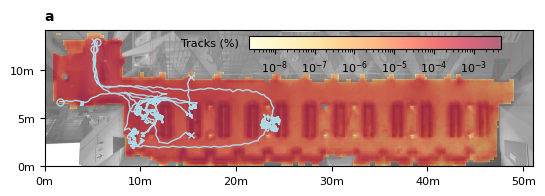

In [ ]:
# Read the HDF5 file
input_file = '../data-clean/tracking/spatial-density.h5'
with h5py.File(input_file, 'r') as hf:
    dates = list(hf.keys())
    results = []
    for date in dates:
        counts = hf[date][:]
        results.append({'date': date, 'counts': counts})

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Merge results with map_dates
merged_df = pd.merge(results_df, map_dates, on='date')

# Sum up the counts overall and normalize them as z scores
overall_counts = np.sum(np.stack(merged_df['counts'].values), axis=0)
overall_props = overall_counts / np.sum(overall_counts)

# Plot the normalized counts overall using the background image
image_path = '../data-raw/background/image3195.png'
image_extent = (0, 51, -0.02, 14.214)

# Determine the min and max for the colorbar
vmin = np.min(overall_props[overall_counts > 0])
vmax = np.max(overall_props)

# Create a masked array where zero counts are masked
masked_counts = np.ma.masked_where(overall_counts == 0, overall_props)

fig, ax = plt.subplots(figsize=(16 / 2.54, 16 / 2.54))

# Set the font sizes
plt.rcParams.update({
    'axes.labelsize': 8,  # Axis labels
    'xtick.labelsize': 8,  # X-axis tick labels
    'ytick.labelsize': 8,  # Y-axis tick labels
    'axes.titlesize': 10   # Title size
})

img = mpimg.imread(image_path)
im = ax.imshow(img, extent=image_extent, aspect='auto')

c = ax.imshow(masked_counts, extent=image_extent, origin='lower', alpha=0.6, cmap='YlOrRd', norm=LogNorm(vmin=vmin, vmax=vmax))

# Set axis labels and ticks
ax.set_xticks([0, 10, 20, 30, 40, 50])
ax.set_xticklabels(['0m', '10m', '20m', '30m', '40m', '50m'])
ax.set_yticks([0, 5, 10])
ax.set_yticklabels(['0m', '5m', '10m'])
ax.tick_params(axis='both', which='major', labelsize=8)

# Remove axis titles
ax.set_xlabel('')
ax.set_ylabel('')

# Add the paths of the sampled tracks
for track_id in sampled_tracks:
    track_data = sampled_tracks_df[sampled_tracks_df['track_id'] == track_id]
    ax.plot(track_data['position_x'], track_data['position_y'], color='lightblue', linewidth=1)
    ax.plot(track_data['position_x'].iloc[0], track_data['position_y'].iloc[0], 'o', color='lightblue', markerfacecolor='none', markersize=5)  # Start
    ax.plot(track_data['position_x'].iloc[-1], track_data['position_y'].iloc[-1], 'x', color='lightblue', markersize=5)  # End

# Add a horizontal colorbar inside the plot
cbar = fig.colorbar(c, ax=ax, orientation='horizontal', fraction=0.05, pad=0.02, shrink=0.5)
cbar.ax.tick_params(labelsize=8)

# Position the colorbar inside the plot
cbar.ax.set_position([0.2, 0.35, 0.9, 0.02])  # [left, bottom, width, height]

# Add the colorbar title to the left of the colorbar
cbar.ax.set_title('Tracks (%)', fontsize=8, loc='left', y=-0.4, position=(-0.27,0))

# Set the overall title
plt.text(0, 1.05, 'a', transform=ax.transAxes, fontsize=10, fontweight='bold', va='bottom', ha='left')

# Save the plot to a file
plt.savefig('../results/spatial-density.png', dpi=300, bbox_inches='tight')
plt.show()

### Occupancy

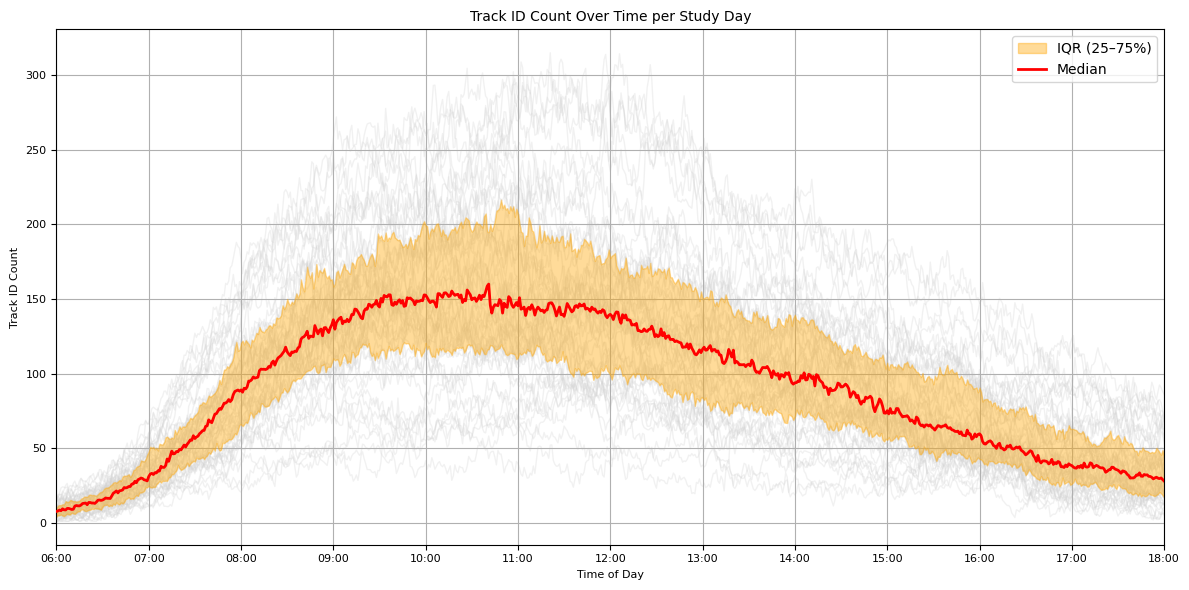

In [102]:
# Ensure datetime format
occ['time_minute'] = pd.to_datetime(occ['time_minute'])

# Create needed columns
occ['study_day'] = occ['time_minute'].dt.date
occ['minutes_since_midnight'] = occ['time_minute'].dt.hour * 60 + occ['time_minute'].dt.minute

# Pivot to get each study day as a column for IQR and median calculation
pivot = occ.pivot_table(index='minutes_since_midnight', columns='study_day', values='track_id_count')

# Compute summary statistics
median_series = pivot.median(axis=1)
q1_series = pivot.quantile(0.25, axis=1)
q3_series = pivot.quantile(0.75, axis=1)

# Filter data from 6am to 6pm
time_mask = (median_series.index >= 360) & (median_series.index <= 1080)
x_vals = median_series.index[time_mask]

# Plotting
plt.figure(figsize=(12, 6))

# Plot all grey lines (faint and behind)
for study_day, group in occ.groupby('study_day'):
    plt.plot(
        group['minutes_since_midnight'],
        group['track_id_count'],
        color='lightgrey',
        alpha=0.3,
        linewidth=1,
        zorder=1
    )

# Plot IQR as shaded area (in front of grey lines)
plt.fill_between(
    x_vals,
    q1_series[time_mask],
    q3_series[time_mask],
    color='orange',
    alpha=0.4,
    label='IQR (25–75%)',
    zorder=2
)

# Plot median line (top layer)
plt.plot(
    x_vals,
    median_series[time_mask],
    color='red',
    linewidth=2,
    label='Median',
    zorder=3
)

# X-axis formatting
plt.xlim(360, 1080)
tick_locs = list(range(360, 1081, 60))  # hourly from 6am to 6pm
tick_labels = [f"{h:02d}:00" for h in range(6, 19)]
plt.xticks(tick_locs, tick_labels)

plt.xlabel('Time of Day')
plt.ylabel('Track ID Count')
plt.title('Track ID Count Over Time per Study Day')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Visit time

/var/folders/0r/py7njh1j56s1qg51ggxjztz00000gp/T/ipykernel_41530/274657700.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(tick*100)}%" for tick in ax.get_yticks()])


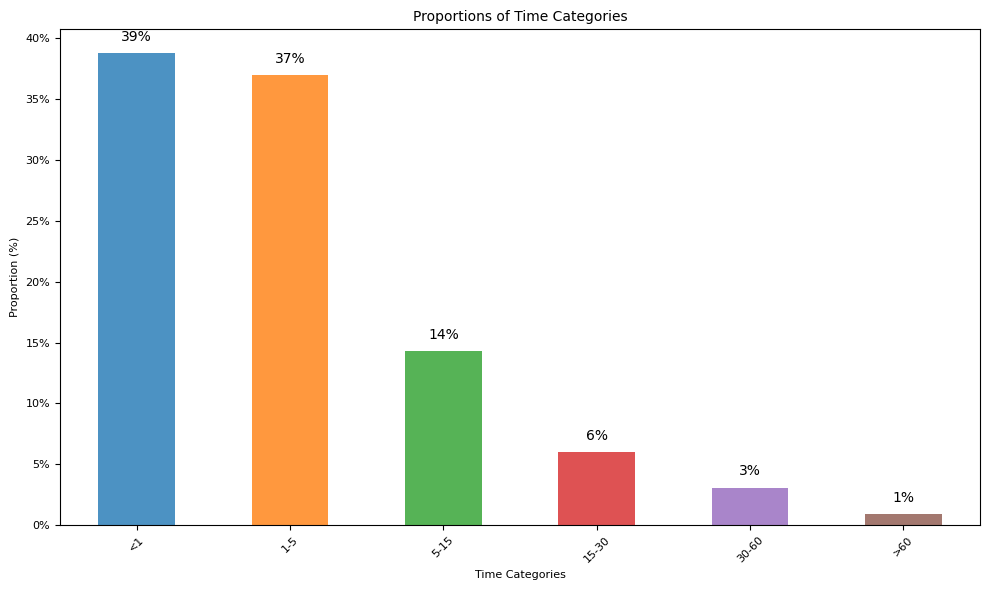

In [ ]:
# Define the time intervals
bins = [0, 1, 5, 15, 30, 60, np.inf]
labels = ['<1', '1-5', '5-15', '15-30', '30-60', '>60']

# Compute the counts and proportions
tt['time_category'] = pd.cut(tt['total_time_in_clinic'] / 60, bins=bins, labels=labels, right=False)
counts = tt['time_category'].value_counts(sort=False)
proportions = counts / counts.sum()

# Plot the stacked barplot
plt.figure(figsize=(10, 6))
ax = proportions.plot(kind='bar', stacked=True, color=plt.cm.tab10.colors, alpha=0.8)

# Add text labels on top of each bar
for i, v in enumerate(proportions):
	ax.text(i, v + 0.01, f"{v*100:.0f}%", ha='center', fontsize=10)

# Update y-axis labels to percentages
ax.set_yticklabels([f"{int(tick*100)}%" for tick in ax.get_yticks()])

plt.title('Proportions of Time Categories')
plt.xlabel('Time Categories')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Close contact

/var/folders/0r/py7njh1j56s1qg51ggxjztz00000gp/T/ipykernel_41530/1662911095.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(tick * 100)}%" for tick in ax.get_yticks()])


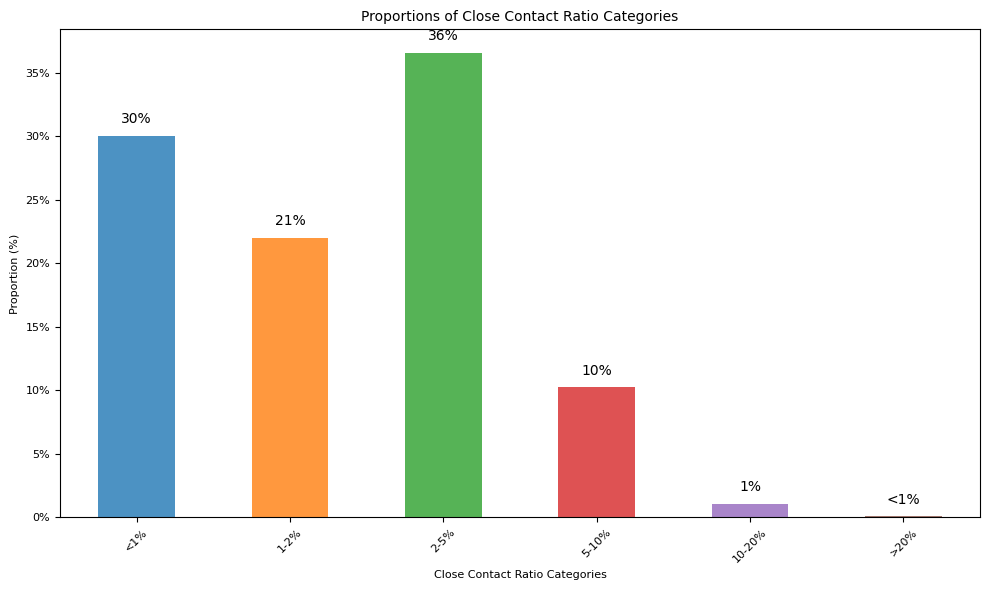

In [97]:
# Categorize close_contact_ratio into bins
bins = [-1, 1, 2, 5, 10, 20, np.inf]
labels = ['<1%', '1-2%', '2-5%', '5-10%', '10-20%', '>20%']
merged_df['close_contact_ratio_category'] = pd.cut(merged_df['close_contact_ratio'], bins=bins, labels=labels, right=False)

# Calculate proportions
proportions = merged_df['close_contact_ratio_category'].value_counts(normalize=True).sort_index()

# Plot the barplot
plt.figure(figsize=(10, 6))
colors = sns.color_palette("tab10", len(proportions))
ax = proportions.plot(kind='bar', color=colors, alpha=0.8)

# Add text labels on top of each bar
for i, v in enumerate(proportions):
	ax.text(i, v + 0.01, f"<1%" if v < 0.005 else f"{int(v * 100)}%", ha='center', fontsize=10)

# Update y-axis labels to percentages
ax.set_yticklabels([f"{int(tick * 100)}%" for tick in ax.get_yticks()])

plt.title('Proportions of Close Contact Ratio Categories')
plt.xlabel('Close Contact Ratio Categories')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Crowding by study phase

In [54]:
# Assume write_pvalue and map_dates are already defined

def compute_entropy(counts):
    counts = counts[counts > 0]  # Exclude zero counts
    total_counts = np.sum(counts)
    p_i = counts / total_counts
    entropy = -np.sum(p_i * np.log(p_i))
    return entropy

def compute_gini(counts):
    counts = counts.flatten()
    counts = counts[counts > 0]  # Exclude zero counts
    n = len(counts)
    diff_sum = np.sum(np.abs(counts[:, None] - counts))
    gini = diff_sum / (2 * n**2 * np.mean(counts))
    return gini

def compute_coefvar(counts):
    counts = counts.flatten()
    counts = counts[counts > 0]  # Exclude zero counts
    x_mean = np.mean(counts)
    x_sigma = np.std(counts)
    coefvar = x_sigma / x_mean
    return coefvar

# Read the HDF5 file
input_file = '../data-clean/tracking/spatial-density.h5'
with h5py.File(input_file, 'r') as hf:
    dates = list(hf.keys())
    results = []
    adjacency_matrix = None
    for date in dates:
        counts = hf[date][:]
        entropy = compute_entropy(counts)
        gini = compute_gini(counts)
        coefvar = compute_coefvar(counts)
        results.append({'date': date, 'entropy': entropy, 'gini': gini, 'coefvar': coefvar})

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)
results_df = pd.merge(results_df, map_dates, on='date', how='left')

In [60]:
# Compute median and IQR by study_phase
summary_stats = results_df.groupby('study_phase').agg(
	median_entropy=('entropy', 'median'),
	q25_entropy=('entropy', lambda x: x.quantile(0.25)),
	q75_entropy=('entropy', lambda x: x.quantile(0.75)),
	median_gini=('gini', 'median'),
	q25_gini=('gini', lambda x: x.quantile(0.25)),
	q75_gini=('gini', lambda x: x.quantile(0.75)),
	median_coefvar=('coefvar', 'median'),
	q25_coefvar=('coefvar', lambda x: x.quantile(0.25)),
	q75_coefvar=('coefvar', lambda x: x.quantile(0.75))
).reset_index()

# Perform Wilcoxon signed-rank test for "First intervention" and "Second intervention" vs "Baseline"
baseline_entropy = results_df[results_df['study_phase'] == 'Baseline']['entropy']
baseline_gini = results_df[results_df['study_phase'] == 'Baseline']['gini']
baseline_coefvar = results_df[results_df['study_phase'] == 'Baseline']['coefvar']

def compute_p_values(phase):
	phase_entropy = results_df[results_df['study_phase'] == phase]['entropy']
	phase_gini = results_df[results_df['study_phase'] == phase]['gini']
	phase_coefvar = results_df[results_df['study_phase'] == phase]['coefvar']
	
	p_entropy = mannwhitneyu(phase_entropy, baseline_entropy).pvalue 
	p_gini = mannwhitneyu(phase_gini, baseline_gini).pvalue 
	p_coefvar = mannwhitneyu(phase_coefvar, baseline_coefvar).pvalue
	
	return p_entropy, p_gini, p_coefvar

# Add p-values to the summary table
p_values = []
for phase in summary_stats['study_phase']:
	if phase == 'Baseline':
		p_values.append((None, None, None))
	else:
		p_values.append(compute_p_values(phase))

summary_stats['p_entropy'] = [p[0] for p in p_values]
summary_stats['p_gini'] = [p[1] for p in p_values]
summary_stats['p_coefvar'] = [p[2] for p in p_values]

# Display the result
print(summary_stats)

           study_phase  median_entropy  q25_entropy  q75_entropy  median_gini  \
0             Baseline        7.532745     7.433005     7.598008     0.754277   
1   First intervention        7.694092     7.561458     7.855181     0.725434   
2  Second intervention        7.682907     7.387366     7.726215     0.724449   

   q25_gini  q75_gini  median_coefvar  q25_coefvar  q75_coefvar  p_entropy  \
0  0.741639  0.773617        2.223009     2.083294     2.338234        NaN   
1  0.681394  0.750833        1.893139     1.625307     2.115202   0.026134   
2  0.711297  0.778591        1.910905     1.856748     2.312637   0.178099   

     p_gini  p_coefvar  
0       NaN        NaN  
1  0.032890   0.006169  
2  0.159382   0.112123  


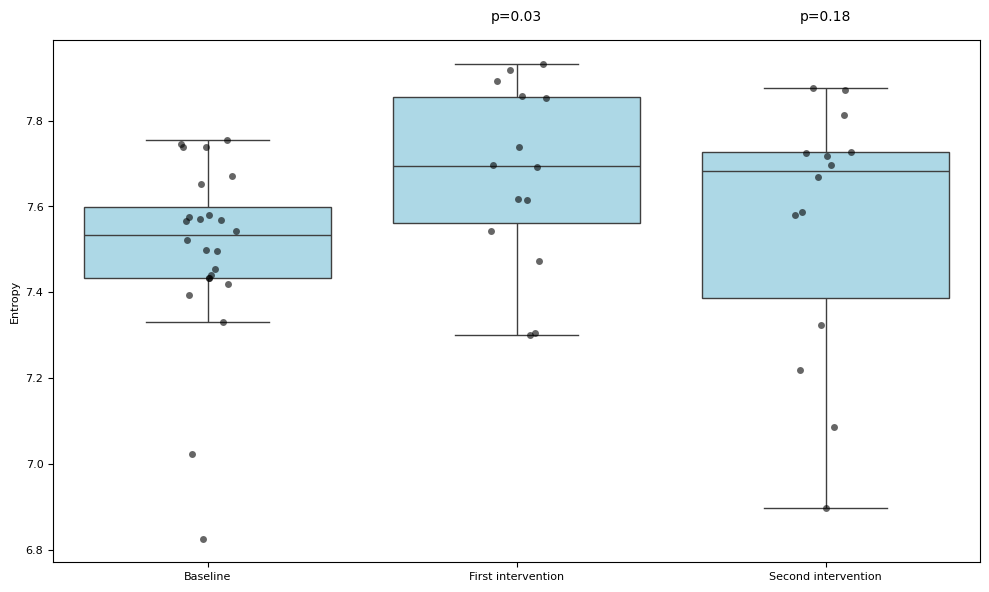

In [95]:
# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='study_phase', y='entropy', showmeans=False, meanline=True, 
			meanprops={"linestyle": "--", "color": "red"}, boxprops={"facecolor": "lightblue"}, showfliers=False)

# Add individual observations as dots with jitter
sns.stripplot(data=results_df, x='study_phase', y='entropy', color='black', alpha=0.6, jitter=True)

# Add p-values on top of the boxplots
p_values = summary_stats[['study_phase', 'p_entropy']].dropna()
for i, row in p_values.iterrows():
	if row['study_phase'] != 'Baseline':  # Skip Baseline
		plt.text(i, results_df['entropy'].max() + 0.1, f"p={row['p_entropy']:.2f}", 
				 ha='center', fontsize=10, color='black')

# Set labels and title
plt.xlabel('')
plt.ylabel('Entropy')
plt.tight_layout()
plt.show()

### Close contact by study phase

In [98]:
# Compute the total number of close_contacts and total_contacts by date
contact_summary = merged_df.groupby(['date', 'study_phase']).agg(
	total_close_contacts=('close_contacts', 'sum'),
	total_contacts=('total_contacts', 'sum')
).reset_index()

# Compute the close_contact_ratio
contact_summary['close_contact_ratio'] = contact_summary['total_close_contacts'] / contact_summary['total_contacts']

In [99]:
# Compute the median and IQR for close_contact_ratio by study_phase
contact_summary_stats = contact_summary.groupby('study_phase')['close_contact_ratio'].describe(percentiles=[0.25, 0.75]).round(2)

# Select only the relevant columns for median and IQR
contact_summary_stats = contact_summary_stats[['50%', '25%', '75%']]
contact_summary_stats.columns = ['Median', 'Q1 (25%)', 'Q3 (75%)']

# Compute p-values comparing "First intervention" and "Second intervention" with "Baseline"
baseline = contact_summary[contact_summary['study_phase'] == 'Baseline']['close_contact_ratio']
first_intervention = contact_summary[contact_summary['study_phase'] == 'First intervention']['close_contact_ratio']
second_intervention = contact_summary[contact_summary['study_phase'] == 'Second intervention']['close_contact_ratio']

p_values = {
    'Baseline': None,
    'First intervention': mannwhitneyu(first_intervention, baseline).pvalue,
    'Second intervention': mannwhitneyu(second_intervention, baseline).pvalue
}

# Add p-values to the summary table
contact_summary_stats['p-value'] = contact_summary_stats.index.map(p_values)

# Display the result
print(contact_summary_stats)

                     Median  Q1 (25%)  Q3 (75%)   p-value
study_phase                                              
Baseline               0.03      0.02      0.03       NaN
First intervention     0.02      0.02      0.03  0.105451
Second intervention    0.02      0.02      0.03  0.058580


/var/folders/0r/py7njh1j56s1qg51ggxjztz00000gp/T/ipykernel_41530/25646960.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values_1 = contact_summary_stats['p-value'][1]
/var/folders/0r/py7njh1j56s1qg51ggxjztz00000gp/T/ipykernel_41530/25646960.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values_2 = contact_summary_stats['p-value'][2]


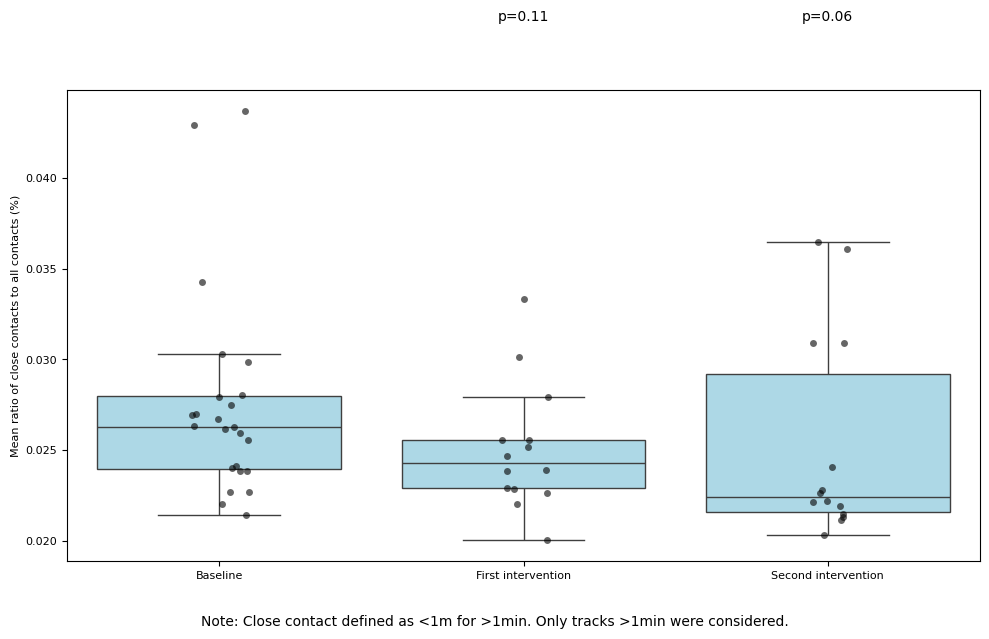

In [100]:
# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=contact_summary, x='study_phase', y='close_contact_ratio', showmeans=False, meanline=True, 
			meanprops={"linestyle": "--", "color": "red"}, boxprops={"facecolor": "lightblue"}, showfliers=False)

# Add individual observations as dots with jitter
sns.stripplot(data=contact_summary, x='study_phase', y='close_contact_ratio', color='black', alpha=0.6, jitter=True)

# Add p-values on top of the boxplots
p_values_1 = contact_summary_stats['p-value'][1]
p_values_2 = contact_summary_stats['p-value'][2]
plt.text(1, contact_summary['close_contact_ratio'].max() + 0.005, f"p={p_values_1:.2f}", 
		 ha='center', fontsize=10, color='black')
plt.text(2, contact_summary['close_contact_ratio'].max() + 0.005, f"p={p_values_2:.2f}",
		 ha='center', fontsize=10, color='black')

# Set labels and title
plt.xlabel('')
plt.ylabel('Mean ratio of close contacts to all contacts (%)')
plt.figtext(0.5, -0.05, 'Note: Close contact defined as <1m for >1min. Only tracks >1min were considered.', ha='center', fontsize=10)
plt.tight_layout()
plt.show()